In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.functional import F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()

In [2]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/Images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle = True, num_workers=4)
              for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    results = {"train": {"loss" : [], "acc": []},\
               "val": {"loss" : [], "acc": []}}
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            results[phase]["loss"].append(epoch_loss)
            results[phase]["acc"].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [4]:
test = image_datasets['train'][0][0][0]
test.shape

test = test.view(1,-1)
test.shape

torch.Size([1, 65536])

In [11]:
class nnet(nn.Module):
    def __init__(self):
        super(nnet, self).__init__()
        
        self.fc1 = nn.Linear(196608, 1080)
        self.fc2 = nn.Linear(1080, 1080)
        self.fc3 = nn.Linear(1080, 360)
        self.fc4 = nn.Linear(360, 64)
        self.fc5 = nn.Linear(64, 2)
        
        
    def forward(self, x):
        
        x = x.view(x.size(0),-1)
        
        out = F.relu(F.dropout(self.fc1(x), p=0.33))
        out = F.relu(F.dropout(self.fc2(out), p=0.33))
        out = F.relu(F.dropout(self.fc3(out), p=0.33))
        out = F.relu(self.fc4(out))
        
        return F.softmax(self.fc5(out), dim=1)

In [12]:
model = nnet()

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
model, model_results = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6423 Acc: 0.6365
val Loss: 0.6245 Acc: 0.6708

Epoch 1/24
----------
train Loss: 0.6258 Acc: 0.6650
val Loss: 0.6120 Acc: 0.6957

Epoch 2/24
----------
train Loss: 0.6219 Acc: 0.6713
val Loss: 0.6098 Acc: 0.6894

Epoch 3/24
----------
train Loss: 0.6115 Acc: 0.6769
val Loss: 0.6114 Acc: 0.7019

Epoch 4/24
----------
train Loss: 0.6118 Acc: 0.6755
val Loss: 0.6061 Acc: 0.6832

Epoch 5/24
----------
train Loss: 0.6113 Acc: 0.6825
val Loss: 0.5999 Acc: 0.7081

Epoch 6/24
----------
train Loss: 0.6026 Acc: 0.6818
val Loss: 0.5999 Acc: 0.7019

Epoch 7/24
----------
train Loss: 0.5919 Acc: 0.7006
val Loss: 0.5900 Acc: 0.7205

Epoch 8/24
----------
train Loss: 0.5913 Acc: 0.7026
val Loss: 0.5878 Acc: 0.6894

Epoch 9/24
----------
train Loss: 0.5896 Acc: 0.7110
val Loss: 0.5883 Acc: 0.7019

Epoch 10/24
----------
train Loss: 0.5857 Acc: 0.7033
val Loss: 0.5954 Acc: 0.7019

Epoch 11/24
----------
train Loss: 0.5878 Acc: 0.6971
val Loss: 0.5870 Acc: 0.7019

Ep

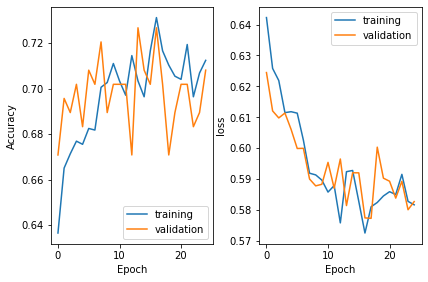

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.tight_layout(pad=1.5)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(model_results["train"][val], label='training')
    axs[i].plot(model_results["val"][val], label = "validation")

axs[0].set(xlabel='Epoch',ylabel='Accuracy')
axs[1].set(xlabel='Epoch',ylabel='loss')
axs[0].legend()
axs[1].legend()